# ADA final exam (Fall 2024)

This exam consists of 2 tasks. The two tasks are independent of each other. You can solve them in any order.

## Task 1: Natural Language Processing (50 pts)
This part of the exam will analyze a real-world negotiation dataset:

Two participants take the role of campsite neighbors and negotiate for Food, Water, and Firewood packages, based on their individual preferences and requirements. This design keeps the task tractable, while still facilitating linguistically rich and personal conversations.

At the end of each negotiation, both negotiators receive an outcome score (`outcome`) reflecting their success in achieving their goals. The dataset is divided into two data frames:

1. `df_negotiations`, with columns:
    - `negotiation_id`: the negotiation identifier
    - `agent`: the agent active in that turn, either `mt_agent_1` or `mt_agent_2` (first and second to interact)
    - `message`: the message sent to the other agent
    - `turn`: the negotiation turn
2. `df_meta`, meta information for each negotiation with the outcome and agent background:
    - `gender`: (male, female, other)
    - `age`: integer
    - `outcome`: integer

We are interested in finding out: what makes a good (/bad) negotiator?

### Part 1: Coding Questions (29 pt)

In [192]:
import pandas as pd

df_negotiations = pd.read_csv('negotiations.csv')
df_negotiations.head()

,agent,message,negotiation_id,turn
0,mturk_agent_1,Hello! 🙂 Let's work together on a deal for the...,0,0
1,mturk_agent_2,Hey! I'd like some more firewood to keep my do...,0,0
2,mturk_agent_1,I need firewood as well. We have a large group...,0,1
3,mturk_agent_2,I see. 😮 What are you least interested in?,0,1
4,mturk_agent_1,We can make do without extra water. Can we tra...,0,2


In [193]:
df_meta = pd.read_csv('negotiations_meta.csv')
df_meta.head()

,agent,age,gender,negotiation_id,outcome
0,mturk_agent_1,31,female,797,21
1,mturk_agent_2,26,male,797,15
2,mturk_agent_1,65,male,909,18
3,mturk_agent_2,34,female,909,23
4,mturk_agent_1,26,male,135,26


**1.1 (2 pt)**
/Discussion:/ We are interested in analyzing negotiation outcomes by analyzing language usage. In order to use TF-IDF to accomplish this, we will treat all turns from one negotiator in a single negotiation as a "document". Why would this definition of "document" be preferred over the following two alternatives? Give at least one argument per alternative.

- A) Each individual turn is a document
- B) The entire negotiation dialogue of both negotiators is a document

Having all the turns from one negotiator in one document is prefered since it allows us to see all the key points this person brought to the debate. This gives a global overview on what was said by this specific person that is in favor or against some points.

The proposition A is less interesting since this "document" format would not capture the whole negotiation. And since this is a dialogue between two persons one turn could just be an answer to the opponent without bringing any new information about the negotiator. Also these turns can be small and not containing a lot of words. This could imply an even sparser TF-IDF matrix with a lot more rows. This proposition would not help us differentiate a good from a bad negotiator.

For answer B since both negotiator turns are merged this implies that we don't have the possibility anymore to differente a good / bad negotiator. This would more give us an insight about is it a good or bad negotiation. But this is not what we are interested in.

**1.2 (3 pt)**

[A, 1 pt] Use the negotiation dataset to create a new dataframe called `df_document` with the following columns:
- `negotiation_id`
- `agent`
- `document`

Here, document is defined as described in question 1.1. That is: concatonate messages into a single string and split by the special character `"\n"`.

In [194]:
df_document = df_negotiations.groupby(["negotiation_id", "agent"])["message"].apply(lambda x : "\n".join(x)).reset_index(name="document")
print(df_document[df_document["negotiation_id"] == 0]["document"].values[1])

Hey! I'd like some more firewood to keep my doggo warm. What do you need?
I see. 😮 What are you least interested in?
We could do without the water as well. I'm willing to trade you 3 firewood for 3 food and 2 waters
I meant I would give you my firewood, what would you trade in return?
I can do that for 3 food and 3 water?
Submit-Deal


[B, 2pt] Next, merge this new dataframe with the `df_meta` dataframe. Print the the size and first five rows of the final dataframe

In [195]:
df_meta1 = df_meta.merge(df_document, on=["negotiation_id", "agent"])
print(f"Size of the df is {df_meta1.size}")
df_meta1.head(5)

Size of the df is 12336


,agent,age,gender,negotiation_id,outcome,document
0,mturk_agent_1,31,female,797,21,Hello. I am also hoping to get extra supplies....
1,mturk_agent_2,26,male,797,15,Hello there! I am looking for extra supplies!🙂...
2,mturk_agent_1,65,male,909,18,hi\nI am. It's really hot here\nHave you given...
3,mturk_agent_2,34,female,909,23,Hello! 🙂 Are you ready to go camping?\nMake su...
4,mturk_agent_1,26,male,135,26,I need to keep the fire burning so i need fire...


**1.3 (7 pt)**
We would like to analyze the difference between "best" and "worst" performers based on `outcome`, top and bottom 10% respectively.

[A, 2 pt] Find the top and bottom 10% thresholds for the `outcome` columns and print them.

In [196]:
df_meta1["outcome"].quantile([0.1, 0.9])

0.1    15.5
0.9    23.0
Name: outcome, dtype: float64

The top 10% threshold is 23 in score and the bottom 10% threshold is 15.5 in score.

[B, 1pt] Create a TF-IDF matrix using the `TfidfVectorizer` form `sklearn`, setting `max_features=100` and `stop_words="english"`. Print the resulting TF-IDF matrix shape.

In [197]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = list(df_meta1["document"].values)

vectorizer = TfidfVectorizer(max_features=100, stop_words="english")
TF_IDF = vectorizer.fit_transform(corpus).toarray()

TF_IDF.shape

(2056, 100)

[C, 4pt] Use your thresholds and the TF-IDF matrix to print the top 10 terms for each type of negotiatior (i.e., the best and worst performing negotiators from question 1.3.A).

In [198]:
import numpy as np

best = df_meta1[df_meta1["outcome"] >= 23]
worst = df_meta1[df_meta1["outcome"] < 15.5]

features = vectorizer.get_feature_names_out()

#We get the TF IDF matrix, keep only the rows that correspond to the top / bottom 10%, sum the rows over the lines so that we get the words that 
# occur the most accross these lines and then we sort them by decreasing and take the top 10.
print(f"Top 10 words for best negotiator (increasing order) : {features[np.argsort(TF_IDF[np.array(best.index), :].sum(axis=0))[-10:]]}")
print(f"Top 10 words for worst negotiators  (increasing order) : {features[np.argsort(TF_IDF[np.array(worst.index), :].sum(axis=0))[-10:]]}")

Top 10 words for best negotiator (increasing order) : ['good' 'submit' 'like' 'camping' 'extra' 'deal' 'need' 'firewood' 'water'
 'food']
Top 10 words for worst negotiators  (increasing order) : ['submit' 'package' 'like' 'packages' 'extra' 'deal' 'need' 'firewood'
 'water' 'food']


**1.4 (8 pt)**
You never get a second chance at a first impression! Let's investigate if the same goes for negotiations...

[A, 1pt] Create a new df_document that only takes into account the first three (3) turns of each negotiator in a negotiation. Again, merge on the df_meta dataframe and print the resulting size.

In [199]:
df_document = df_negotiations.groupby(["negotiation_id", "agent"])["message"].apply(lambda x : "\n".join(x[:3])).reset_index(name="document")
print(df_document[df_document["negotiation_id"] == 0]["document"].values[1])

df_meta2 = df_meta.merge(df_document, on=["negotiation_id", "agent"])
print(f"Size of the df is {df_meta2.size}")
df_meta2.head(5)

Hey! I'd like some more firewood to keep my doggo warm. What do you need?
I see. 😮 What are you least interested in?
We could do without the water as well. I'm willing to trade you 3 firewood for 3 food and 2 waters
Size of the df is 12336


,agent,age,gender,negotiation_id,outcome,document
0,mturk_agent_1,31,female,797,21,Hello. I am also hoping to get extra supplies....
1,mturk_agent_2,26,male,797,15,Hello there! I am looking for extra supplies!🙂...
2,mturk_agent_1,65,male,909,18,hi\nI am. It's really hot here\nHave you given...
3,mturk_agent_2,34,female,909,23,Hello! 🙂 Are you ready to go camping?\nMake su...
4,mturk_agent_1,26,male,135,26,I need to keep the fire burning so i need fire...


[B, 1pt] Calculate the median negotiation outcome. Then, add a column called success to the df_document dataframe that is 1 if the outcome column is more than the median and 0 otherwise. Print the median outcome.

In [200]:
median_outcome = df_meta2["outcome"].median()
print(median_outcome)

df_meta2["success"] = (df_meta2["outcome"] > median_outcome).astype(int)
df_meta2.head(5)

19.0


,agent,age,gender,negotiation_id,outcome,document,success
0,mturk_agent_1,31,female,797,21,Hello. I am also hoping to get extra supplies....,1
1,mturk_agent_2,26,male,797,15,Hello there! I am looking for extra supplies!🙂...,0
2,mturk_agent_1,65,male,909,18,hi\nI am. It's really hot here\nHave you given...,0
3,mturk_agent_2,34,female,909,23,Hello! 🙂 Are you ready to go camping?\nMake su...,1
4,mturk_agent_1,26,male,135,26,I need to keep the fire burning so i need fire...,1


[C, 2pt] Create a TF-IDF matrix called `X` based on `df_document` using the following settings:

`max_features=100, stop_words="english, ngram_range=(1, 2)`

Additionally, create a variable `y` that corresponds to the success column. Finally, use `sklearn.model_selection.train_test_split` to split your data into a train and test set using parameters `test_size=0.2` and `random_state=99`.

Print the shape of the TF-IDF and the shape of your train and test sets.

In [201]:
from sklearn.model_selection import train_test_split

corpus = list(df_meta2["document"].values)
vectorizer = TfidfVectorizer(max_features=100, stop_words="english", ngram_range=(1,2))
X = vectorizer.fit_transform(corpus).toarray()
y = np.array(df_meta2["success"].values)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2056, 100) (2056,)
(1644, 100) (1644,)
(412, 100) (412,)


[D, 2pt] Use your prepared data to train a logistic regression model (`sklearn.linear_model.LogisticRegression`). Then, with the trained model predict on the test set and print a classification report (`sklearn.metrics.classification_report`).

In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression().fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      0.92      0.74       258
           1       0.22      0.04      0.07       154

    accuracy                           0.59       412
   macro avg       0.42      0.48      0.40       412
weighted avg       0.47      0.59      0.49       412



[E, 2pt] Use the weights of your trained model to show which terms mostly strongly correlate with high and low outcomes. Print the best five terms for each.

In [203]:
bottom_coefs = clf.coef_.argsort(axis=1)[:, :5]
top_coefs = clf.coef_.argsort(axis=1)[:, -5:]

feature_names = vectorizer.get_feature_names_out()

print(f"Top words that predict high incomes are : {list([feature_names[elem] for elem in top_coefs])[0]}")
print(f"Bottom words that predict low incomes are : {list([feature_names[elem] for elem in bottom_coefs][0])}")


Top words that predict high incomes are : ['nice' 'packages' 'firewood water' 'need extra' 'really need']
Bottom words that predict low incomes are : ['sounds', 'getting', 'little', 'time', 'know']


**1.5 (9 pt)**
You are concerned about potential “confounding” factors for your results in the previous question. Specifically, you would like to investigate the effect of “gender” on the outcomes.

[A, 3pt] Visualize the outcomes stratified by gender using a bar plot with standard deviation around the mean. Make sure you use clear x- and y-axis labels, a title, and a legend.

Text(0.5, 0.98, 'Outcome value stratified by gender showing stddev arround mean and with y log scale')

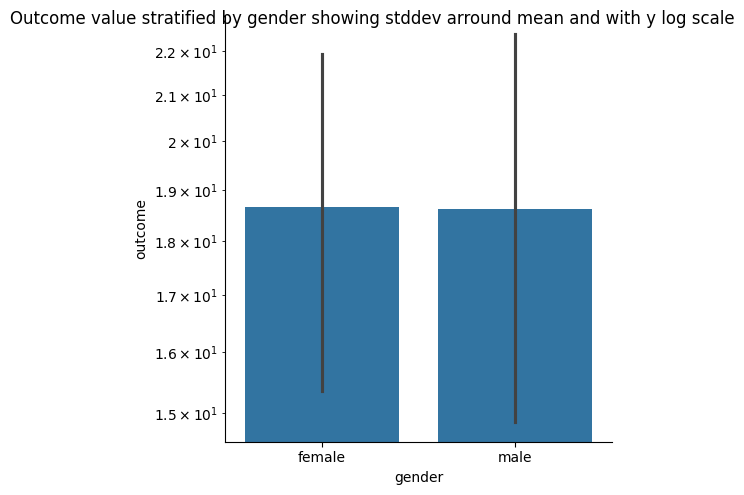

In [204]:
import seaborn as sns

ax = sns.catplot(df_meta2, x=df_meta2["gender"], y=df_meta2["outcome"], kind="bar",log=True, errorbar="sd")
ax.fig.suptitle("Outcome value stratified by gender showing stddev arround mean and with y log scale")

[B, 2pt] Perform a T-Test with a confidence interval of 0.95 to check if the outcomes based on gender are statistically significantly different. Print the resulting t-statistic, the p-value, and your interpretation of the result.

In [205]:
import scipy.stats as stats

stats.ttest_ind(df_meta2[df_meta2["gender"] == "male"]["outcome"], df_meta2[df_meta2["gender"] == "female"]["outcome"])

TtestResult(statistic=-0.1518207180233982, pvalue=0.8793432508556187, df=2054.0)

P > 0.05 so we can't reject the null hypothesis that the two independent samples have identical average (expected) values. This implies that the gender has probably no impact on the outcome.

[C, 2pt] Finally, we would like to test if the gender distribution between high and low negotiation performers is significantly different. Please perform a chi-square test on the gender distribution of those negotiators scoring above the median outcome. Use a confidence interval of 0.95 and print the resulting chi-square statistic, p-value, and your interpretation of the result.

In [206]:
from scipy.stats import chisquare

chisquare(df_meta2[df_meta2["success"] == 1]["gender"] == "female")

Power_divergenceResult(statistic=385.0, pvalue=1.0)

P > 0.05 so we can't reject the null hypothesis that the two genders have the same distribution. 
This implies that probably there is no gender difference either in the top scoring negotiators.

[D, 2pt] /Discuss:/ In addition to the gender attribute, could you think of other measurable factors in this dataset that could be tested as confounders? List at least two more and explain why.

We could use the age because we could imagine that older persons have more experience in negotiations and can perform better.

We could use the length of the debate since longer negotiaitons could show that it was more tight between the two negotiators.

We could use the information of which negotiator spoke first as this can destabilize the other negotiaoti.

### Part 2: Insight Questions (15 pt)

**2.1 (3pt)**
In the context of analyzing negotiation turns, why would TF-IDF be more suitable than simple word frequency counts when trying to identify distinctive communication patterns between successful and unsuccessful negotiations?

Word frequency does not take into account the inverse document frequency as the TFIDF matrix. This implies that the issue of semantically irrelevant words having the highest term frequency in a bag of words model is removed in the tf idf matrix.
Our models are thus not biased by non relevant words and can focus on more important words. 

**2.2 (2pt)**
How would you modify the standard TF-IDF implementation to account for the temporal nature of negotiation turns? Consider that early turns might be more important for setting the tone of the negotiation than later turns.

We could scale the TF matrix by the turns. So if we have 7 turns then the first turn is scaled by 8 the second by 7 until the last one that is only scaled by 1. This increases the probabilities in the rows that appear at the beginning then the IDF matrix will rescale this to remove the irrelevant words.

**2.3 (3 pt)**
In our negotiation dataset, successful negotiators might simply write longer messages. How could this create a misleading interpretation of our TF-IDF results, and what would be a simple way to test for this potential bias?

With longer messages, the TF-iDF row corresponding to this message will be filled with more data so it is less sparse and this can give more insights on the models we train.

A simple way would be to let all the words in the tfidf matrix and not limit it to the 100 highest features.

**2.4 (3pt)**
In our negotiation dataset, consider these two opening messages from different agents:

Agent A: "I propose we split the resources fairly" Agent B: "I suggest we divide the assets equitably"

These messages are semantically very similar but use different vocabulary. Explain:

- a) How TF-IDF would process these messages differently
- b) How word embeddings (like Word2Vec) would handle them
- c) Why this distinction matters for negotiation analysis

A : Different columns will be filled by these words in the TF IDF matrix. This implies that our subsequent models, when using these rows to make predictions will learn different weights and thus possibly not predict the same outcomes.

B : Word embeddings take into account the semantic closeness of sentences. This implies that two sentences that have a similar meaning will have similar embeddings.

C : This matters since here in our case we found that our models are not very robust and not really accurate. Probably it would be better using word embeddings.
This matters alos since a lot of sentences can be repeated to argue for or against and this implies that a lot of rephrasing is done which harms TFIDF matrices.

**2.5 (4pt)**
Staying in the context of negotiations, explain why N-gram models such as bigrams might be more informative than unigrams for predicting negotiation outcomes. Provide two examples of bigrams that would be particularly meaningful in negotiation contexts but would lose their significance if split into unigrams.

Bi grams could capture pair of words that are related. So naturally two words give more information than only one word.

Here in this case the "don't agree" bi gram shows that a negotiator is not agrreing with the other. But if we take the don't and agree separated we loose this information and we could predict agreement if we saw the token agree but the opposite was meant.

another example would be "least interested" if taken separated this could bias predictions in the wrong directions.

## Task 2: Analysis of Co-Author Network (50 pts)


In this part, you will analyze a reserach publication dataset derived from 
[social influence analysis in large-scale networks](https://keg.cs.tsinghua.edu.cn/jietang/publications/KDD09-Tang-et-al-Social-Influence-Analysis.pdf) (the paper itself is irrelevant to this exam, don't waste time reading it).

The citation data is extracted from DBLP, ACM, MAG (Microsoft Academic Graph), and other sources. Each paper is associated with abstract, authors, year, venue, and title.

Dataset: [citation dataset](https://cn.aminer.org/citation)

Paper: [social influence analysis in large-scale networks](https://keg.cs.tsinghua.edu.cn/jietang/publications/KDD09-Tang-et-al-Social-Influence-Analysis.pdf)


### Download data from the web

#### For Linux and MacOS:
```bash
wget https://lfs.aminer.cn/lab-datasets/citation/citation-network1.zip
unzip citation-network1.zip
ls -l outputacm.txt
```

#### For windows we recommend using WSL (Windows Subsystem for Linux) with above commands or directly downloading the file from the browser at 
https://lfs.aminer.cn/lab-datasets/citation



In [207]:
import numpy as np
import pandas as pd
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt

from helper import load_data_as_df


# Define the file path
file_path = "outputacm.txt"

# Load the data into a DataFrame
df = load_data_as_df(file_path)

# check if the index column is the same as the index 

print(f"Dataset loaded with {len(df)} entries.")
print(f"colums: {df.columns}")

Dataset loaded with 629814 entries.
colums: Index(['title', 'authors', 'year', 'venue', 'references', 'abstract'], dtype='object')


**3.1 (6 pts)**: Analyze Papers Published Per Year

**Objective:**  
Analyze and visualize publication trends to understand how the research field has evolved over time.

#### Instructions:
1. Group the data by the year of publication and count the number of papers for each year (2 pts).
2. Plot a bar chart showing the number of papers published per year from **1990 to 2010**. (2 pts)
3. Focus on the pattern between **1996 and 2004**:
   - **Discuss:** Describe any notable trends or changes in the number of publications during this period. (2 pts)
   - **Bonus:** Hypothesize potential reasons for the observed pattern.  (2 pts)
     *Hint: Consider events or trends related to the dataset's focus on computer science.* 


Text(0.5, 1.0, 'Papers per year between 1990 and 2010')

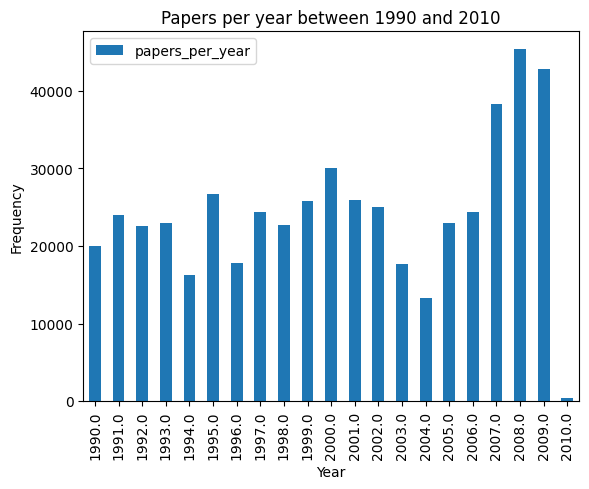

In [219]:
paper_y = df.groupby("year").size().reset_index(name="papers_per_year")


paper_y[(paper_y.year <= 2010) & (paper_y.year >= 1990)].plot(kind="bar", x="year", y="papers_per_year")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Papers per year between 1990 and 2010")

Between 1996 and 2000 the number of papers published increased nearly constantly and then from 2000 to 2004 it decreased and went to the minimum number of papers ever published in a year (if 2010 is discarded)

**3.2 (4 pts)**: Authors Per Paper Analysis

With the rise of interdisciplinary research, multi-authored papers are becoming more common. This task will help us understand collaboration dynamics in the academic world.

#### Instructions:
- Get the number of authors for each paper and calculate the percentage of papers with four or more authors. (2 pts)
- Plot a histogram to show the frequency distribution of the number of authors per paper (2 pts)(choose `bins=range(0, 30)` and set y-axis to log scale).

In [228]:
df["nbr_authors"] = df["authors"].apply(lambda x : len(x))
print(f"""{round(len(df[df["nbr_authors"] >= 4]) / len(df) * 100, 3)}% of the papers are published with 4 or more authors""")

13.174% of the papers are published with 4 or more authors


Text(0.5, 1.0, 'Frequency distribution of the number of authors per paper (with y log scale)')

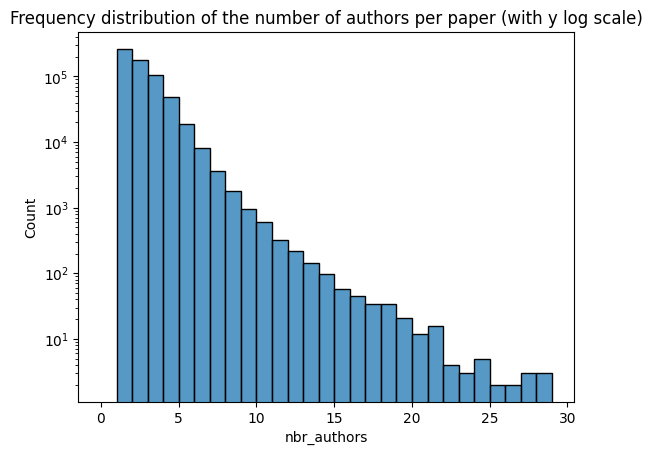

In [237]:
ax = sns.histplot(data=df, x="nbr_authors", bins=range(0,30))
ax.set_yscale("log")
ax.set_title("Frequency distribution of the number of authors per paper (with y log scale)")

**3.3 (4 pts)**: Temporal Collaboration Trends

Collaboration dynamics can change over time. This task will help us understand how collaboration trends have evolved in the academic world.

#### Instructions:
- Group the data by publication year, calculate the average number of authors per paper for each year, and create a line plot to visualize how it has changed from 1990 to 2010 (1 pt).
- **Discuss:** There has been a hypothesis that the number of authors per paper has increased over time. Based on the plot, do you agree with this hypothesis ? (1 pt)
- Compute the P-value of the hypothesis that the average number of authors per paper after 2000 is significantly higher than before 2000. (2 pts)

Text(0.5, 1.0, 'Mean number of authors per paper per year between 1990 and 2010')

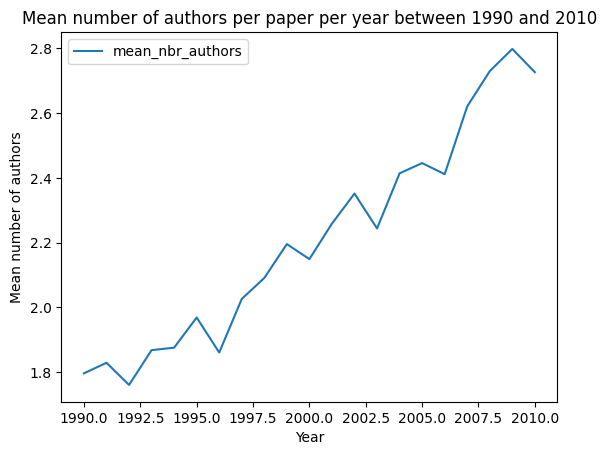

In [243]:
data = df.groupby("year")["nbr_authors"].apply(lambda x : x.mean()).reset_index(name = "mean_nbr_authors")
data[(data.year <= 2010) & (data.year >= 1990)].plot(kind = "line", x="year", y = "mean_nbr_authors")

plt.xlabel("Year")
plt.ylabel("Mean number of authors")
plt.title("Mean number of authors per paper per year between 1990 and 2010")

Yes this plots shows a cureve that is nearly always increasing over the years. So the global trend that we could conclude is that yes there are more authors per paper over time.

In [244]:
data

,year,mean_nbr_authors
0,1900.0,1.000000
1,1941.0,1.000000
2,1947.0,2.000000
3,1949.0,2.000000
4,1950.0,1.000000
...,...,...
61,2007.0,2.620667
62,2008.0,2.729605
63,2009.0,2.798189
64,2010.0,2.726316


In [246]:
stats.ttest_ind(data[data["year"] <= 2000]["mean_nbr_authors"], data[data["year"] > 2000]["mean_nbr_authors"])

TtestResult(statistic=-7.678901971057288, pvalue=1.1872937816736868e-10, df=64.0)

The p value is < 0.05 so we can reject the null hypothesis that the two samples have the same average and thus we can say that the two means are different. And the number of authors per paper increased.

**3.4 (6 pts)**: Build a Co-Author Network

Co-author networks help us visualize and quantify collaborations in academia. Such networks are critical for identifying influential researchers and their role in fostering connections within their communities. Construct a network where nodes represent authors and edges represent collaborations.

#### Instructions:
- Create a graph where: (5 pts)
  - Nodes: Each node represents a unique author, identified by their name in the authors field of the dataset.
  - Edges: There is an edge between two nodes if the corresponding authors have co-authored at least one paper. The weight of the edge represents the number of papers the two authors have co-authored together.
- After constructing the network, print the following information: (1 pt)
  - The total number of nodes (authors) in the network.
  - The total number of edges (collaborations) in the network.

Example:

For a paper authored by ["Alice", "Bob", "Charlie"], the graph should include:
- Nodes: Alice, Bob, Charlie.
- Edges: Alice-Bob, Alice-Charlie, Bob-Charlie, each with a weight of 1 (assuming no other collaborations between these pairs).


In [275]:
import itertools
from collections import Counter

list(itertools.combinations(["alice", "bob", "charlie"], 2))

[('alice', 'bob'), ('alice', 'charlie'), ('bob', 'charlie')]

In [280]:
nodes = []
edges = []
for elem in df["authors"]:
    nodes.extend(elem)
    edges.extend(list(itertools.combinations(elem, 2)))
nodes = set(nodes)
edges = dict(Counter(edges))

In [298]:
import networkx as nx
G = nx.MultiGraph()

G.add_nodes_from(nodes)
G.add_weighted_edges_from([(k[0], k[1], v) for k, v in edges.items()])

In [299]:
print(G)

MultiGraph with 595775 nodes and 1178657 edges


**3.5 (4 pts)**: Analyze the Co-Author Network

Connected components in a co-author network can reveal isolated research communities or dominant research hubs. Analyzing the largest component helps us understand the core of academic collaboration

#### Instructions:
- The degree of a node is the number of edges connected to it. In the context of the co-author network, this represents the number of distinct co-authors an author has collaborated with. Compute the average degree of the network (1 pt).
- Connectivity of the Network:
  - A network is fully connected if there is a path between every pair of nodes. Determine if the co-author network is fully connected (2 pt). (Hint: A single answer is not enough here. You need to use a method to verify the connectivity of the network.)
  - Can you tell how many authors are part of the largest connected component? How much does this account for the total number of authors in the network? (2 pt)
<!-- - Compute the average clustering coefficient of the network. -->

In [312]:
print(f"Is the graph fully connected : {nx.is_connected(G)}")

Is the graph fully connected : False


In [311]:
largest_cc = max(nx.connected_components(G), key=len)
print(len(largest_cc))
print(f"This represents {len(largest_cc) / len(G.nodes) * 100}% of the nodes")

342738
This represents 57.52809365951911% of the nodes


**3.6 (4 pts)**: Top Authors by Collaborations

#### Instructions:
- Get the degree for all nodes in the network and print the top 10 authors by degree (1 pt) (Note: some entries (e.g., "II," "III," "Jr.") may not represent real authors due to data quality issues. Please keep them in the list and don't do any cleaning.)
- A high degree  indicates that an author has collaborated with many other authors. However, it does not consider if the collaborations happen multiple times between the same authors. A weighted degree would be a better measure to consider the number of collaborations between authors. Get the top 10 authors by weighted degree. P.S. The weighted degree is the sum of the weights of the edges connected to the node. (1 pt)
- Which two authors have the highest number of collaborations? How many papers have they co-authored together? (2 pt)

In [313]:
sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]


[(' Jr.', 6587),
 (' III', 1388),
 (' II', 807),
 ('Wei Wang', 352),
 ('Ming Li', 257),
 ('Wei Li', 238),
 ('Elisa Bertino', 227),
 ('Lei Zhang', 211),
 ('Hector Garcia-Molina', 211),
 ('Philip S. Yu', 210)]

In [314]:
sorted(G.degree(weight="weight"), key=lambda x: x[1], reverse=True)[:10]


[(' Jr.', 9083),
 (' III', 1836),
 (' II', 1059),
 ('Philip S. Yu', 476),
 ('Wei Wang', 471),
 ('Elisa Bertino', 416),
 ('Ming Li', 382),
 ('Ron Kikinis', 359),
 ('Thomas J. Cashman', 338),
 ('Hector Garcia-Molina', 334)]

In [317]:
sorted(G.edges(data=True), key=lambda edge: edge[2].get('weight', 1))[-1]


('Thomas J. Cashman', 'Gary B. Shelly', {'weight': 154})

'Thomas J. Cashman' and  'Gary B. Shelly' have the highest number of collaborations and they worked on 154 papers

**3.7 (4 pts)**: Analyze the reference/citation information 

Understanding the citation patterns of papers helps reveal their academic impact and how knowledge propagates through the research community. In this task, you will analyze the reference and citation relationships within the dataset.

First, let's create a citation network where:
- Nodes: Each node represents a unique paper, identified by its id in the dataset.
- Edges: There is an edge from paper A to paper B if paper A cites paper B. 


#### Instructions:
- **Discuss:** Is it reasonable that the citation network contains cycles?  What would a cycle( not self loop) in the citation network represent? (2 pt)
- Which paper has the highest number of citations? How many papers cite this paper? (1 pt)
- Which paper has the highest number of references? How many papers does this paper cite? (1 pt)


In [ ]:
# TODO

**3.8 (3 pts)**: Analyze the Citation Distribution 

The citation distribution of papers can provide insights into the impact of research publications. In this task, you will analyze the citation distribution in the dataset.

<!-- - Plot the number of papers having a certain level of citation x (x-axis) against x (y-axis) in a log-log scale. -->
- Create a frequency distribution where the x-axis represents the number of citations and the y-axis represents the number of papers that have that number of citations. Plot two scatters plot of the frequency distribution first in a normal scale and second in a log-log scale. (2 pts)
- **Discuss**: What does the plot suggest about the citation distribution in the dataset? (1 pt)

In [ ]:
# TODO

**3.9 (3 pts)**: Central Tendency of Citation Distribution

**Discuss:**: There are different ways to describe the central tendency of a citation distribution., such as mean. Determine the measure you think best represents the dataset and explain your reasoning. (Hint: Consider the distribution of the citation data above)


In [ ]:
# TODO

**3.10 (2pts)**: Network Centrality Measures

PageRank is a measure of influence based on link structure. Applying it to citations allows us to rank papers by their academic importance

#### Instructions:
- You are tasked with curating the 'Top 10 Influential Papers' from this dataset. Use PageRank to justify your selection and display the top 10 papers titles by page rank. (2 pts)
- **bonus**: Identify patterns among the top-ranked papers. (2 pts)


In [ ]:
# TODO

**3.11 (5 pts)**: Bridge Papers

Bridge papers are those that connect different research communities. They are essential for fostering interdisciplinary research and knowledge transfer. 

#### Instructions: 
- Build a small citation network that only includes papers published in 2005. (2 pts)
- Which measurement can help us identify bridge papers in a citation network?  (2 pt)
- Try to find top10 bridge papers in the dataset. By looking at their titles, can you identify the research communities they connect? (Pick 2 papers) (1 pt)



In [ ]:
# TODO

**3.12 (5 pts)**: Author-Citation Network

In the previous tasks, we analyzed the co-author network and paper-citation network. In this task, we will analyze the author-citation network, where:
- Nodes: Each node represents a unique author, identified by their name in the authors field of the dataset.
- Edges: There is an edge from author A to author B if author A cites a paper authored by author B. 
- The weight of the edge represents the total number of citations from author A to author B.

#### Instructions:
- Given that we have a Author-Paper Matrix $A$ where each row represents an paper and each column represents an author. The value in the matrix is 1 if the author has contributed to the paper, 0 otherwise. And we also have a Paper-Paper citation matrix $P$ (square matrix) where the value at coordinates (i, j) is 1 if paper j cites paper i, 0 otherwise.
- How can you get a Author-Author citation matrix from the above two matrices by matrix multiplication? (You don't need to implement this, just give the formula) (2 pts)
- Author A may have never cited author B, but author A might have cited a few papers which cited works by author B. This can be seen as a 2nd degree citation.  More formally, a 2nd degree citation matrix $C_2$ has at each cell (i, j) the number 2nd degree citations from author i to author j. How can you get a 2nd degree citation matrix from the Author-Paper Matrix $A$ and Paper-Paper citation matrix $P$? (You don't need to implement this, just give the formula) (2 pts)
- Can you generalize this to nth degree citation matrix? (1 pt)

In [ ]:
# TODO